In [1]:
from priors import *
from container import *
from client import *
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from logreg import *

# Loading the dataset, and initializing clients with distributed data

In [2]:
MNIST = torchvision.datasets.MNIST(root = ".", 
                                   train = True,
                                   download = True,transform=torchvision.transforms.ToTensor())

output_dimension = len(MNIST.classes)
input_dimension = len(MNIST.data[0])**2
hidden_size = 10

#good lr for log-reg
model = nn.Linear(input_dimension, output_dimension)
lr = 1e-5
n_clients = 20

models = init_clients(MNIST, n_clients, model, lr, prior = Gaussian(0, 0.1))

# Defining Loss function and initializing distributed container

In [3]:
loss_criterion = nn.CrossEntropyLoss()
distributed_models = Container(models, loss_criterion)

# Test loop dataset and Definition

In [4]:
MNIST_test = torchvision.datasets.MNIST(root = ".", 
                                   train = False,
                                   download = True,
                                        transform=torchvision.transforms.ToTensor())

batch_size = 100

test_loader = DataLoader(MNIST_test, batch_size = batch_size)

In [5]:
def test(distributed_models, test_loader):
    with torch.no_grad():
        loss = []
        total = 0
        correct = 0
        for batch in test_loader:
            total += len(batch[0])
            y_i = distributed_models(batch[0]).softmax(dim = 1)
            loss.append(loss_criterion(y_i, batch[1]))
            correct += torch.eq(y_i.argmax(dim = 1), batch[1]).sum()

        accuracy = correct/total
        avg_loss = sum(loss)/len(loss)

    return(accuracy, avg_loss)

# Training the model

In [6]:
training_loss = []
for i in range(1000):
    loss = distributed_models.train(batch_size,.8)
    training_loss.append(loss.item())
    
    if i % 100 == 0:
        print('epoch: ', i, ' loss: ', loss.item())

epoch:  0  loss:  133.91152954101562
epoch:  100  loss:  26.875274658203125
epoch:  200  loss:  23.407094955444336
epoch:  300  loss:  17.563440322875977
epoch:  400  loss:  20.278776168823242
epoch:  500  loss:  18.18461799621582
epoch:  600  loss:  16.205764770507812
epoch:  700  loss:  17.661991119384766
epoch:  800  loss:  18.39556121826172
epoch:  900  loss:  16.711610794067383


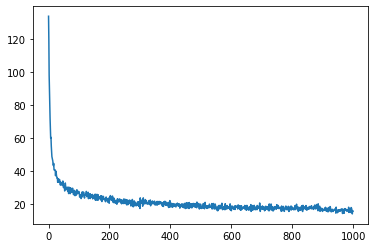

In [7]:
plt.plot(training_loss)

In [8]:
acc, avg_loss = test(distributed_models, test_loader)
print(acc, avg_loss)

tensor(0.9153) tensor(2.1314)
